# Gradient-based Optimization

Optimizing a lens using PyTorch optimizers.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

import optiland.backend as be
from optiland.optic import Optic
from optiland.materials import IdealMaterial
from optiland.analysis import SpotDiagram

In [2]:
be.set_backend("torch")  # all calculations will be done using torch
be.set_precision("float32")  # or "float64" for double precision
be.grad_mode.enable()  # enable gradient calculation. Can also be set to "disable" to save memory if gradients are not needed.
be.set_device("cuda")  # run on GPU if available, otherwise use "cpu" option

In [3]:
class Singlet(Optic):
    """A simple singlet lens"""

    def __init__(self):
        super().__init__()
        ideal_material = IdealMaterial(n=1.5, k=0)

        self.add_surface(index=0, radius=be.inf, thickness=be.inf)
        self.add_surface(
            index=1, thickness=5.0, radius=100.0, is_stop=True, material=ideal_material
        )
        self.add_surface(index=2, radius=-50.0, thickness=65.0)
        self.add_surface(index=3)

        self.set_aperture(aperture_type="EPD", value=25)

        self.set_field_type(field_type="angle")
        self.add_field(y=0)

        self.add_wavelength(value=0.55, is_primary=True)

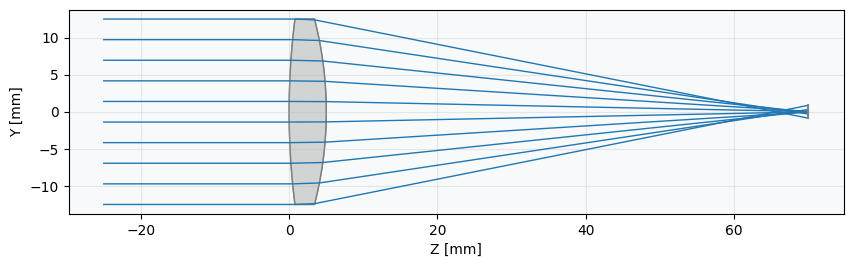

In [4]:
optic = Singlet()
optic.draw(num_rays=10)

In [5]:
# Define parameters for optimization - radii of both surfaces
params = [
    optic.surface_group.surfaces[1].geometry.radius,
    optic.surface_group.surfaces[2].geometry.radius,
]

In [6]:
# Define torch optimizer - we use Adam
optimizer = optim.Adam(params, lr=1.0)

In [7]:
num_iterations = 1000

loss_values = []

for k in range(num_iterations):
    # == zero gradients ==
    optimizer.zero_grad()

    # == compute loss function ==
    spot = SpotDiagram(optic)
    # convert from 2D tensor to scalar
    loss = spot.rms_spot_radius()[0][0]

    # == compute gradients ==
    loss.backward()

    # == step optimizer ==
    optimizer.step()

    loss_values.append(loss.item())

    if (k + 1) % 100 == 0:
        print(
            f"Iteration {k + 1}/{num_iterations}, Loss (RMS Spot Radius): {loss.item():.6f} mm"
        )

Iteration 100/1000, Loss (RMS Spot Radius): 0.186711 mm
Iteration 200/1000, Loss (RMS Spot Radius): 0.163222 mm
Iteration 300/1000, Loss (RMS Spot Radius): 0.140186 mm
Iteration 400/1000, Loss (RMS Spot Radius): 0.125758 mm
Iteration 500/1000, Loss (RMS Spot Radius): 0.117216 mm
Iteration 600/1000, Loss (RMS Spot Radius): 0.111742 mm
Iteration 700/1000, Loss (RMS Spot Radius): 0.108024 mm
Iteration 800/1000, Loss (RMS Spot Radius): 0.105290 mm
Iteration 900/1000, Loss (RMS Spot Radius): 0.103213 mm
Iteration 1000/1000, Loss (RMS Spot Radius): 0.101592 mm


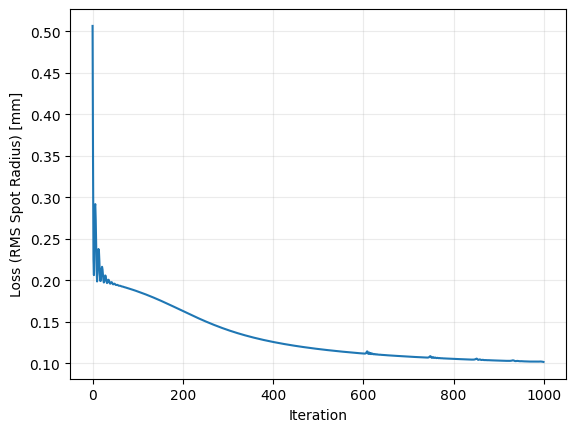

In [8]:
plt.plot(range(num_iterations), loss_values)
plt.xlabel("Iteration")
plt.ylabel("Loss (RMS Spot Radius) [mm]")
plt.grid(alpha=0.25)
plt.show()